In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing libraries

In [13]:
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix,precision_recall_fscore_support

In [14]:
files0 =glob.glob('/content/drive/MyDrive/chest_xray/*/NORMAL/*')
files1 =glob.glob('/content/drive/MyDrive/chest_xray/*/PNEUMONIA/*')

Sample Data

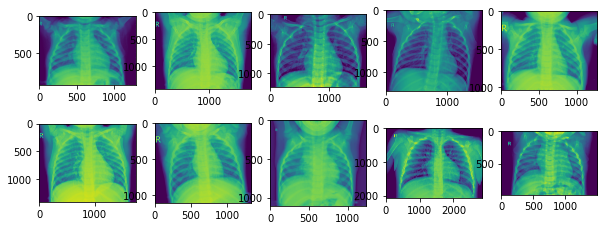

In [44]:
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.imshow(Image.open(files0[i]))

plt.show()

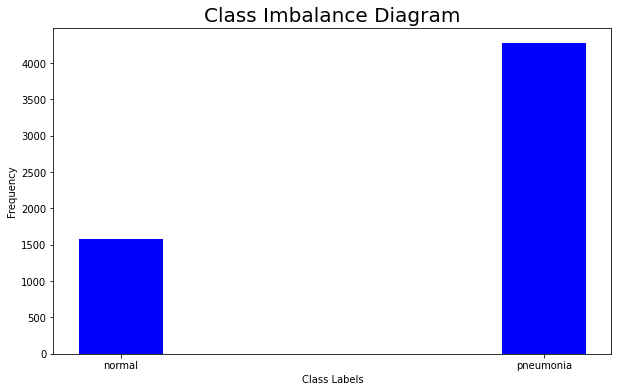

In [16]:
plt.figure(figsize = (10, 6))
plt.bar(['normal','pneumonia'], [len(files0),len(files1)],width=0.2, color="blue")
plt.xlabel("Class Labels")
plt.ylabel("Frequency")
plt.title("Class Imbalance Diagram", fontsize=20)
plt.show()

In [17]:
DIMENSIONS = 100

Loading Data

In [18]:
def load_images(files0,files1):
    all_images=[]
    all_labels=[]
    for f in files0:
        im=Image.open(f).convert('L').resize((DIMENSIONS,DIMENSIONS))
        img=np.array(im).flatten()/255
        all_images.append(img)
        all_labels.append(0)
    for f in files1:
        im=Image.open(f).convert('L').resize((DIMENSIONS,DIMENSIONS))
        img=np.array(im).flatten()/255
        all_images.append(img)
        all_labels.append(1)
    return all_images, all_labels
all_images, all_labels= load_images(files0,files1)

Standardizing Data

In [19]:
def standarize(x):
    mean = np.mean(x)  
    std = np.std(x)  
    x = (x- mean) / std
    return mean,std,x
_mean,_std,images_st=standarize(np.array(all_images))

Data After Preprocessing

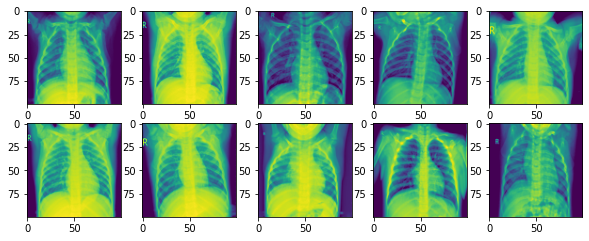

In [41]:
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.imshow(images_st[i].reshape(100,100))

Applying PCA

In [21]:
pca= PCA(n_components=0.95)
pca=pca.fit(images_st)

In [22]:
img_pca=pca.transform(images_st)

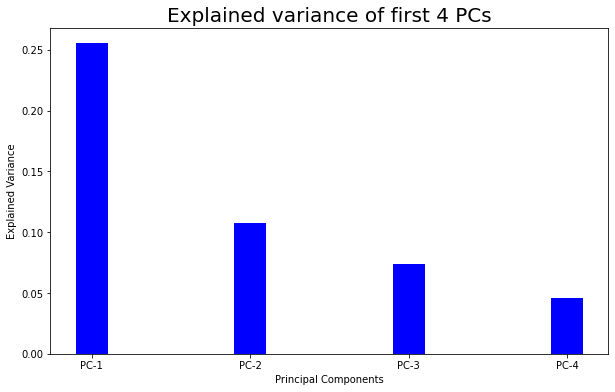

In [25]:
var=pca.explained_variance_ratio_
plt.figure(figsize = (10, 6))
plt.bar([f"PC-{i+1}" for i in range(4)], list(var[:4]),width=0.2, color="blue")
plt.xlabel("Principal Components")
plt.ylabel("Explained Variance")
plt.title("Explained variance of first 4 PCs", fontsize=20)
plt.show()

Data after PCA application

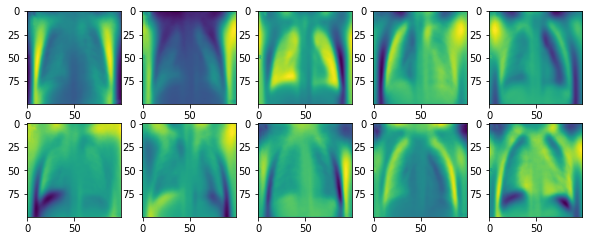

In [ ]:
plt.figure(figsize=(10,10))
eigen_cell=pca.components_
l=eigen_cell.shape[0]
eigen_cell=eigen_cell.reshape(323,100,100)
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.imshow(eigen_cell[i])

Train test splitting

In [38]:
X_train, X_test, y_train, y_test = train_test_split(img_pca, np.array(all_labels),
                                    test_size = 0.3, random_state = 111)

Naive Bayes Classification

CPU times: user 87.6 ms, sys: 5.96 ms, total: 93.6 ms
Wall time: 94 ms
Test Accuracy : 78.88446215139442%
Train Accuracy : 77.6286899243718%
Precision: 74.07095552380305%
Recall : 78.22611476614263%
Fscore: 75.29150173094847%


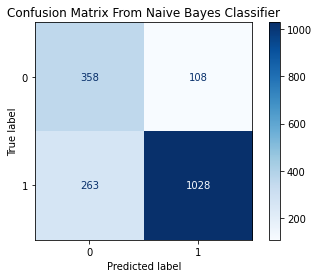

In [28]:
from sklearn.naive_bayes import GaussianNB
clf=GaussianNB()
%time clf.fit(X_train, y_train)
train_acc=metrics.accuracy_score(y_train, clf.predict(X_train))
test_acc=metrics.accuracy_score(y_test, clf.predict(X_test))
m=precision_recall_fscore_support(y_test, clf.predict(X_test), average='macro')
print(f"Test Accuracy : {test_acc*100}%\nTrain Accuracy : {train_acc*100}%\nPrecision: {m[0]*100}%\nRecall : {m[1]*100}%\nFscore: {m[2]*100}%" )
com=confusion_matrix(y_test, clf.predict(X_test)) 
disp = ConfusionMatrixDisplay(confusion_matrix=com)
disp.plot(cmap =plt.cm.Blues)
plt.title(f"Confusion Matrix From Naive Bayes Classifier")
plt.show()

Support Vector Machines (SVM) Classification

CPU times: user 1.99 s, sys: 9.84 ms, total: 2 s
Wall time: 2.01 s
Test Accuracy : 92.54410927717701%
Train Accuracy : 94.77921444254697%
Precision: 93.05720869193676%
Recall : 87.5212348281101%
Fscore: 89.81088107788179%


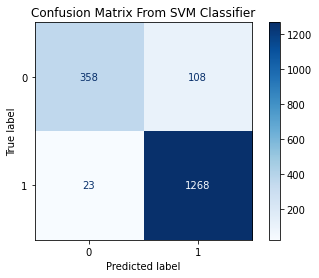

In [29]:
clf = svm.SVC(kernel = "poly",C=0.5, random_state=111)
%time clf.fit(X_train, y_train)
m=precision_recall_fscore_support(y_test, clf.predict(X_test), average='macro')
train_acc=metrics.accuracy_score(y_train, clf.predict(X_train))
test_acc=metrics.accuracy_score(y_test, clf.predict(X_test))
print(f"Test Accuracy : {test_acc*100}%\nTrain Accuracy : {train_acc*100}%\nPrecision: {m[0]*100}%\nRecall : {m[1]*100}%\nFscore: {m[2]*100}%" )
com=confusion_matrix(y_test, clf.predict(X_test)) 
disp = ConfusionMatrixDisplay(confusion_matrix=com)
disp.plot(cmap =plt.cm.Blues)
plt.title(f"Confusion Matrix From SVM Classifier")
plt.show()

Multilayer Perceptron (MLP) Classification

In [30]:

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.preprocessing import OneHotEncoder
y_ = np.array(all_labels).reshape(-1, 1)
encoder = OneHotEncoder(sparse=False)
y__ = encoder.fit_transform(y_)
model = Sequential()
model.add(Dense(10, input_shape=(img_pca.shape[1],), activation='relu', name='fc1')) #4
model.add(Dense(10, activation='relu', name='fc2'))
model.add(Dense((len(np.unique(y_))), activation='sigmoid', name='output'))
optimizer = Adam(lr=0.001)
print(model.summary())
train_x, test_x, train_y, test_y = train_test_split(img_pca, y__, test_size=0.3,random_state = 111)
model.compile(optimizer, loss='binary_crossentropy', metrics=['accuracy'])
%time history = model.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=100, verbose=0)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (Dense)                 (None, 10)                3240      
                                                                 
 fc2 (Dense)                 (None, 10)                110       
                                                                 
 output (Dense)              (None, 2)                 22        
                                                                 
Total params: 3,372
Trainable params: 3,372
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


None
CPU times: user 42.8 s, sys: 2.91 s, total: 45.7 s
Wall time: 39.2 s


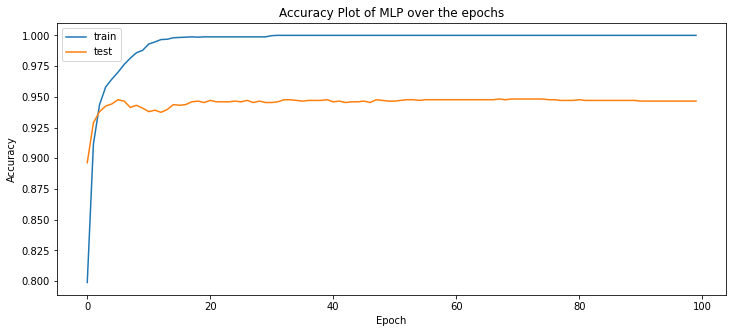

In [31]:
plt.figure(figsize=(12,5))
plt.title('Accuracy Plot of MLP over the epochs')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [32]:

 
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
r=model.predict(test_x)
pred=[]
for i in range(len(r)):
  pred.append(np.argmax(r[i]))
pred = np.array(pred)
y_or = np.argmax(test_y, axis=1)
accuracy = accuracy_score(y_or, pred)
precision = precision_score(y_or, pred)
recall = recall_score(y_or, pred)
f1 = f1_score(y_or, pred)
print(f"Accuracy : {accuracy*100}%\nPrecision: {precision*100}%\nRecall : {recall*100}%\nFscore: {f1*100}%" )
_, train_acc = model.evaluate(train_x, train_y, verbose=0)
print("Training accuracy:",str(train_acc*100) +"%")

55/55 [==============================] - 0s 1ms/step
Accuracy : 94.64997154240183%
Precision: 96.35941130906274%
Recall : 96.35941130906274%
Fscore: 96.35941130906274%
Training accuracy: 100.0%


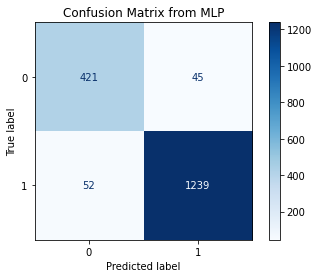

In [19]:
com=confusion_matrix(y_or, pred) 
disp = ConfusionMatrixDisplay(confusion_matrix=com)
disp.plot(cmap =plt.cm.Blues)
plt.title(f"Confusion Matrix from MLP")
plt.show()

Saving trained model

In [33]:
model.save("/content/drive/MyDrive/model.h5")

Making Prediction on demo data

Text(50, 5, 'PNEUMONIA')

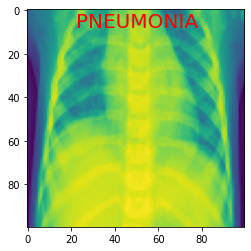

In [27]:

from keras.models import load_model
model1 = load_model('/content/drive/MyDrive/model.h5')
im=Image.open('/content/drive/MyDrive/test.jpeg').convert('L').resize((DIMENSIONS,DIMENSIONS))
img=np.array(im).flatten()/255
img_test = (img- _mean) / _std
img_test=img_test.reshape(1,-1)
pca_test = pca.transform(img_test)
r=model1.predict(pca_test,verbose=0)
if np.argmax(r[0])==1 :
  output="PNEUMONIA"
else:
  output="NORMAL"
plt.imshow(im)
plt.text(50, 5, output, horizontalalignment='center',
     verticalalignment='center',fontsize=20, color='r')